### Data

https://www.robots.ox.ac.uk/~vgg/data/flowers/102/

Inspo: https://colab.research.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL?usp=sharing#scrollTo=Rj17psVw7Shg

In [45]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

In [46]:


# Hyperparameters
T = 300  # Total number of diffusion steps
beta_start = 0.0001
beta_end = 0.02
beta_schedule = torch.linspace(beta_start, beta_end, T)
alpha_schedule = 1 - beta_schedule
alpha_bar_schedule = torch.cumprod(alpha_schedule, dim=0)

# Helper function to show tensor image
def show_tensor_image(image):
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    image = image.permute(1, 2, 0).clip(0, 1)
    plt.imshow(image)
    plt.axis('off')


# You can use any dataset, here's an example with CIFAR-10
dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)


1.3%

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data


### Forward Process - *Noise scheduler*

Adds noise to training images in a controlled way.

Need to build the inputs for our model, which are more and more noisy images. Instead of doing this sequentially, we can use the closed form provided in the papers to calculate the image for any of the timesteps individually

In [47]:
import torch.nn.functional as F

In [48]:
# A linear schedule for noise levels (B) from start to end, over the specified number of steps. This schedule controls how much noise is added at each step.
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)


# This function:
    # takes a list of values, timesteps t, and the shape of the input
    # returns the appropriate values for each timestep in the batch
    # reshapes the output to match the input dimensions
    
def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape)-1))).to(t.device)



# Main forward diffusion function
"""
Implements the forward diffusion process equation:

q(x_t|x_0) = √(ᾱ_t)x_0 + √(1-ᾱ_t)ε
where:

x_0 is the original image
ε is random noise
ᾱ_t is the cumulative product of alphas up to time t
"""
def forward_diffusion_sample(x_0, t, device="cpu"):
    noise = torch.randn_like(x_0)  # Generate random noise
    # Get the pre-computed alpha values for timestep t
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # Apply the forward diffusion formula
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Pre-compute terms used in both forward and reverse diffusion processes
"""
β_t (betas): The noise schedule
α_t (alphas): 1 - β_t
ᾱ_t (alphas_cumprod): The cumulative product of alphas
These values control the signal-to-noise ratio at each timestep
"""
T = 300  # Total number of timesteps
betas = linear_beta_schedule(timesteps=T)  # Create beta schedule

# Pre-calculate various terms used in the diffusion process
alphas = 1. - betas  # α_t = 1 - β_t
alphas_cumprod = torch.cumprod(alphas, axis=0)  # ᾱ_t = ∏(1 - β_t)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)  # ᾱ_{t-1}
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)  # 1/√α_t
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)  # √ᾱ_t
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)  # √(1-ᾱ_t)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

Let's test it on our dataset

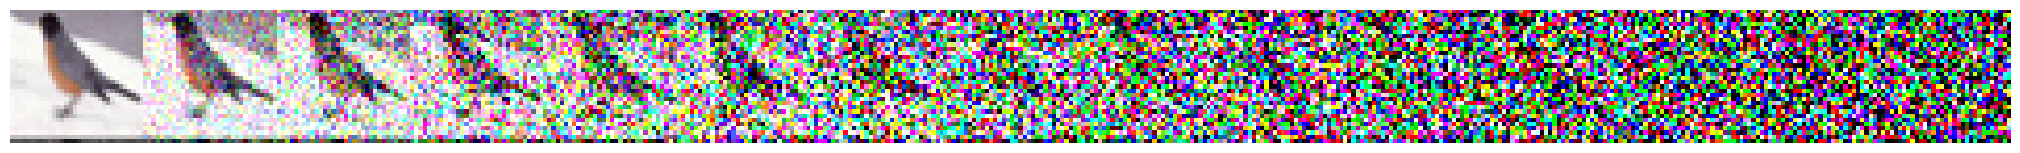

In [73]:
# Simulate forward diffusion

image = next(iter(dataloader))[0]
num_images = 15
stepsize = int(T/num_images)

# Create figure with minimal spacing
plt.figure(figsize=(20, 2))
for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)
    plt.axis('off')

# Remove spacing between subplots
plt.subplots_adjust(wspace=0, hspace=0)
plt.margins(0, 0)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)

# Remove any remaining whitespace around the figure
plt.gca().set_axis_off()
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.show()

### Backward process